# Loading packages

In [1]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
from tqdm.notebook import tqdm
import lightgbm as lgb
pd.options.display.max_columns = 50
import os
os.chdir("/Users/Paritosh_Gupta/Downloads/kaggle/m5_fore_acc/m5-forecasting-accuracy/")




# Input Parameters

In [2]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
pd.options.display.max_columns = 50
h = 28 
max_lags = 57
FIRST_DAY = 350
# tr_last = 1913
tr_last = 1913 + 28
# fday = datetime(2016,4, 25)
fday = datetime(2016,4, 25) + timedelta(days= 28)
fday,tr_last,max_lags



(datetime.datetime(2016, 5, 23, 0, 0), 1941, 57)

# udf

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
#     dt = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
#                      nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    dt = pd.read_csv("sales_train_evaluation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    print("reducing memory")
    dt = reduce_mem_usage(dt)
    return dt

def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")
     
    print("reducing memory")
    dt = reduce_mem_usage(dt)
    
def merging_tables(df1, df2):
    a = df1.columns
    b = df2.columns
    common_cols = [x for x in a if x in b]
    print(common_cols)
    out = pd.merge(df1, df2, on=common_cols, how="inner")
    return out

def merging_tables_left(df1, df2):
    a = df1.columns
    b = df2.columns
    common_cols = [x for x in a if x in b]
    print(common_cols)
    out = pd.merge(df1, df2, on=common_cols, how="left")
    return out


# ADS Preparation

## Merge base tables

In [4]:
%%time
df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape



reducing memory
Mem. usage decreased to 2339.12 Mb (26.2% reduction)
CPU times: user 26 s, sys: 6.99 s, total: 33 s
Wall time: 33 s


(41571939, 22)

In [5]:
df.head()


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.970703
1,HOBBIES_1_004_CA_1_evaluation,3,0,0,0,0,d_350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,4.339844
2,HOBBIES_1_005_CA_1_evaluation,4,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,2.480469
3,HOBBIES_1_008_CA_1_evaluation,7,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,0.500000
4,HOBBIES_1_009_CA_1_evaluation,8,0,0,0,0,d_350,2.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,1.769531


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41571939 entries, 0 to 41571938
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int8          
 3   store_id      int8          
 4   cat_id        int8          
 5   state_id      int8          
 6   d             object        
 7   sales         float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int8          
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(5), int16(3), int8(11), object(2)


## Seasonality calculation

### sales seasonality

In [7]:
## Sales Seasonality
## weekly
df_weekly_tmp_1 = pd.DataFrame(df.groupby(['id', 'wday'])['sales'].mean().reset_index())
df_weekly_tmp_1.rename(columns = {"sales":"sales_weekly"}, inplace=True)

df_weekly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sales'].mean().reset_index())
df_weekly_tmp_2.rename(columns = {"sales":"sales_overall"}, inplace=True)

df_weekly_season_sales = pd.merge(df_weekly_tmp_1,df_weekly_tmp_2, how = 'outer')
df_weekly_season_sales["weekly_si_sales"] = (df_weekly_season_sales['sales_weekly']/df_weekly_season_sales['sales_overall'])
df_weekly_season_sales.drop(['sales_weekly', 'sales_overall'], axis=1, inplace=True)
print(df_weekly_season_sales.shape)


########### monthly
df_monthly_tmp_1 = pd.DataFrame(df.groupby(['id', 'month'])['sales'].mean().reset_index())
df_monthly_tmp_1.rename(columns = {"sales":"sales_monthly"}, inplace=True)

df_monthly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sales'].mean().reset_index())
df_monthly_tmp_2.rename(columns = {"sales":"sales_overall"}, inplace=True)

df_monthly_season_sales = pd.merge(df_monthly_tmp_1,df_monthly_tmp_2, how = 'outer')
df_monthly_season_sales["monthly_si_sales"] = (df_monthly_season_sales['sales_monthly']/df_monthly_season_sales['sales_overall'])
df_monthly_season_sales.drop(['sales_monthly', 'sales_overall'], axis=1, inplace=True)
print(df_monthly_season_sales.shape)

## yearly

df_yearly_tmp_1 = pd.DataFrame(df.groupby(['id', 'year'])['sales'].mean().reset_index())
df_yearly_tmp_1.rename(columns = {"sales":"sales_yearly"}, inplace=True)

df_yearly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sales'].mean().reset_index())
df_yearly_tmp_2.rename(columns = {"sales":"sales_overall"}, inplace=True)

df_yearly_season_sales = pd.merge(df_yearly_tmp_1,df_yearly_tmp_2, how = 'outer')
df_yearly_season_sales["yearly_si_sales"] = (df_yearly_season_sales['sales_yearly']/df_yearly_season_sales['sales_overall'])
df_yearly_season_sales.drop(['sales_yearly', 'sales_overall'], axis=1, inplace=True)
print(df_yearly_season_sales.shape)


(213430, 3)
(365338, 3)
(138381, 3)


### price seasonality

In [8]:
# ## sell_price Seasonality
# ## weekly
# df_weekly_tmp_1 = pd.DataFrame(df.groupby(['id', 'wday'])['sell_price'].mean().reset_index())
# df_weekly_tmp_1.rename(columns = {"sell_price":"sell_price_weekly"}, inplace=True)

# df_weekly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sell_price'].mean().reset_index())
# df_weekly_tmp_2.rename(columns = {"sell_price":"sell_price_overall"}, inplace=True)

# df_weekly_season_sell_price = pd.merge(df_weekly_tmp_1,df_weekly_tmp_2, how = 'outer')
# df_weekly_season_sell_price["weekly_si_sell_price"] = (df_weekly_season_sell_price['sell_price_weekly']/df_weekly_season_sell_price['sell_price_overall'])
# df_weekly_season_sell_price.drop(['sell_price_weekly', 'sell_price_overall'], axis=1, inplace=True)
# print(df_weekly_season_sell_price.shape)


# ########### monthly
# df_monthly_tmp_1 = pd.DataFrame(df.groupby(['id', 'month'])['sell_price'].mean().reset_index())
# df_monthly_tmp_1.rename(columns = {"sell_price":"sell_price_monthly"}, inplace=True)

# df_monthly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sell_price'].mean().reset_index())
# df_monthly_tmp_2.rename(columns = {"sell_price":"sell_price_overall"}, inplace=True)

# df_monthly_season_sell_price = pd.merge(df_monthly_tmp_1,df_monthly_tmp_2, how = 'outer')
# df_monthly_season_sell_price["monthly_si_sell_price"] = (df_monthly_season_sell_price['sell_price_monthly']/df_monthly_season_sell_price['sell_price_overall'])
# df_monthly_season_sell_price.drop(['sell_price_monthly', 'sell_price_overall'], axis=1, inplace=True)
# print(df_monthly_season_sell_price.shape)

# ## yearly

# df_yearly_tmp_1 = pd.DataFrame(df.groupby(['id', 'year'])['sell_price'].mean().reset_index())
# df_yearly_tmp_1.rename(columns = {"sell_price":"sell_price_yearly"}, inplace=True)

# df_yearly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sell_price'].mean().reset_index())
# df_yearly_tmp_2.rename(columns = {"sell_price":"sell_price_overall"}, inplace=True)

# df_yearly_season_sell_price = pd.merge(df_yearly_tmp_1,df_yearly_tmp_2, how = 'outer')
# df_yearly_season_sell_price["yearly_si_sell_price"] = (df_yearly_season_sell_price['sell_price_yearly']/df_yearly_season_sell_price['sell_price_overall'])
# df_yearly_season_sell_price.drop(['sell_price_yearly', 'sell_price_overall'], axis=1, inplace=True)
# print(df_yearly_season_sell_price.shape)


In [9]:
### check missing value count
print(df_weekly_season_sales.isna().sum().sum())
print(df_monthly_season_sales.isna().sum().sum())
print(df_yearly_season_sales.isna().sum().sum())
# print(df_weekly_season_sell_price.isna().sum().sum())
# print(df_monthly_season_sell_price.isna().sum().sum())
# print(df_yearly_season_sell_price.isna().sum().sum())

7
12
5


## Merge seasonality features

In [10]:
print(df.shape)
print("## Merging SALES!! seasonalities columns......")
print("Merging WEEKLY seasonality - SALES!!")
df = merging_tables(df, df_weekly_season_sales)
print(df.shape)
print("Merging MONTHLY seasonality - SALES!!")
df = merging_tables(df, df_monthly_season_sales)
print(df.shape)
print("Merging YEARLY seasonality - SALES!!")
df = merging_tables(df, df_yearly_season_sales)
print(df.shape)

# print("## Merging SELL_PRICE seasonalities columns......")
# print(df.shape)
# print("Merging WEEKLY seasonality - SELL_PRICE!!!")
# df = merging_tables(df, df_weekly_season_sell_price)
# print(df.shape)
# print("Merging MONTHLY seasonality - SELL_PRICE!!!")
# df = merging_tables(df, df_monthly_season_sell_price)
# print(df.shape)
# print("Merging YEARLY seasonality - SELL_PRICE!!!")
# df = merging_tables(df, df_yearly_season_sell_price)
# print(df.shape)


(41571939, 22)
## Merging SALES!! seasonalities columns......
Merging WEEKLY seasonality - SALES!!
['id', 'wday']
(41571939, 23)
Merging MONTHLY seasonality - SALES!!
['id', 'month']
(41571939, 24)
Merging YEARLY seasonality - SALES!!
['id', 'year']
(41571939, 25)


In [11]:
# df_weekly_season_sales

In [12]:
df.isna().sum()

id                     0
item_id                0
dept_id                0
store_id               0
cat_id                 0
state_id               0
d                      0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1           0
event_type_1           0
event_name_2           0
event_type_2           0
snap_CA                0
snap_TX                0
snap_WI                0
sell_price             0
weekly_si_sales     1592
monthly_si_sales    1592
yearly_si_sales     1592
dtype: int64

In [13]:
print(df.columns)
df.head(20)

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'weekly_si_sales',
       'monthly_si_sales', 'yearly_si_sales'],
      dtype='object')


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekly_si_sales,monthly_si_sales,yearly_si_sales
0,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.970703,1.063477,0.556641,0.909668
1,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_357,0.0,2012-01-20,11151,0,7,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.063477,0.556641,0.909668
2,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_364,0.0,2012-01-27,11152,0,7,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.063477,0.556641,0.909668
3,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_351,0.0,2012-01-14,11151,2,1,1,2012,0,0,0,0,0.0,0.0,1.0,3.970703,1.365234,0.556641,0.909668
4,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_358,0.0,2012-01-21,11152,2,1,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.365234,0.556641,0.909668
5,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_365,0.0,2012-01-28,11201,2,1,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.365234,0.556641,0.909668
6,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_352,0.0,2012-01-15,11151,3,2,1,2012,0,0,0,0,0.0,1.0,1.0,3.970703,1.126953,0.556641,0.909668
7,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_359,1.0,2012-01-22,11152,3,2,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.126953,0.556641,0.909668
8,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_366,1.0,2012-01-29,11201,3,2,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.126953,0.556641,0.909668
9,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_353,0.0,2012-01-16,11151,1,3,1,2012,14,2,0,0,0.0,0.0,0.0,3.970703,0.796875,0.556641,0.909668


In [14]:
df = reduce_mem_usage(df)

Mem. usage decreased to 2577.00 Mb (0.0% reduction)


## Create additional features

In [15]:
%%time

create_fea(df)
df.shape



reducing memory
Mem. usage decreased to 3171.69 Mb (5.9% reduction)
CPU times: user 1min 38s, sys: 11.6 s, total: 1min 49s
Wall time: 1min 49s


(41571939, 34)

In [16]:
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 41571939 entries, 0 to 41571938
Data columns (total 34 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                object        
 1   item_id           int16         
 2   dept_id           int8          
 3   store_id          int8          
 4   cat_id            int8          
 5   state_id          int8          
 6   d                 object        
 7   sales             float16       
 8   date              datetime64[ns]
 9   wm_yr_wk          int16         
 10  weekday           int8          
 11  wday              int8          
 12  month             int8          
 13  year              int16         
 14  event_name_1      int8          
 15  event_type_1      int8          
 16  event_name_2      int8          
 17  event_type_2      int8          
 18  snap_CA           float16       
 19  snap_TX           float16       
 20  snap_WI           float16       
 21  sell_p

In [17]:
df.head()


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekly_si_sales,monthly_si_sales,yearly_si_sales,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.970703,1.063477,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
1,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_357,0.0,2012-01-20,11151,0,7,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.063477,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,3,1,20
2,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_364,0.0,2012-01-27,11152,0,7,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.063477,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,4,1,27
3,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_351,0.0,2012-01-14,11151,2,1,1,2012,0,0,0,0,0.0,0.0,1.0,3.970703,1.365234,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,2,1,14
4,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_358,0.0,2012-01-21,11152,2,1,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.365234,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,3,1,21


In [18]:
df = reduce_mem_usage(df)

Mem. usage decreased to 3171.69 Mb (0.0% reduction)


## write file

In [19]:
df.reset_index(drop=True, inplace=True)
df.to_feather('ads_m5_forecasting_demand.ftr')  



# Read ADS

In [4]:
df = pd.read_feather('ads_m5_forecasting_demand.ftr')
df.shape

(41571939, 34)

In [5]:
print(df.columns)
df.head()

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'weekly_si_sales',
       'monthly_si_sales', 'yearly_si_sales', 'lag_7', 'lag_28', 'rmean_7_7',
       'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week', 'quarter', 'mday'],
      dtype='object')


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,weekly_si_sales,monthly_si_sales,yearly_si_sales,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_350,0.0,2012-01-13,11150,0,7,1,2012,0,0,0,0,0.0,1.0,0.0,3.970703,1.063477,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,2,1,13
1,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_357,0.0,2012-01-20,11151,0,7,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.063477,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,3,1,20
2,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_364,0.0,2012-01-27,11152,0,7,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.063477,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,4,1,27
3,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_351,0.0,2012-01-14,11151,2,1,1,2012,0,0,0,0,0.0,0.0,1.0,3.970703,1.365234,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,2,1,14
4,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_358,0.0,2012-01-21,11152,2,1,1,2012,0,0,0,0,0.0,0.0,0.0,3.970703,1.365234,0.556641,0.909668,NaN,NaN,NaN,NaN,NaN,NaN,3,1,21


In [6]:
## Sales Seasonality
## weekly
df_weekly_tmp_1 = pd.DataFrame(df.groupby(['id', 'wday'])['sales'].mean().reset_index())
df_weekly_tmp_1.rename(columns = {"sales":"sales_weekly"}, inplace=True)

df_weekly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sales'].mean().reset_index())
df_weekly_tmp_2.rename(columns = {"sales":"sales_overall"}, inplace=True)

df_weekly_season_sales = pd.merge(df_weekly_tmp_1,df_weekly_tmp_2, how = 'outer')
df_weekly_season_sales["weekly_si_sales"] = (df_weekly_season_sales['sales_weekly']/df_weekly_season_sales['sales_overall'])
df_weekly_season_sales.drop(['sales_weekly', 'sales_overall'], axis=1, inplace=True)
print(df_weekly_season_sales.shape)


########### monthly
df_monthly_tmp_1 = pd.DataFrame(df.groupby(['id', 'month'])['sales'].mean().reset_index())
df_monthly_tmp_1.rename(columns = {"sales":"sales_monthly"}, inplace=True)

df_monthly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sales'].mean().reset_index())
df_monthly_tmp_2.rename(columns = {"sales":"sales_overall"}, inplace=True)

df_monthly_season_sales = pd.merge(df_monthly_tmp_1,df_monthly_tmp_2, how = 'outer')
df_monthly_season_sales["monthly_si_sales"] = (df_monthly_season_sales['sales_monthly']/df_monthly_season_sales['sales_overall'])
df_monthly_season_sales.drop(['sales_monthly', 'sales_overall'], axis=1, inplace=True)
print(df_monthly_season_sales.shape)

## yearly

df_yearly_tmp_1 = pd.DataFrame(df.groupby(['id', 'year'])['sales'].mean().reset_index())
df_yearly_tmp_1.rename(columns = {"sales":"sales_yearly"}, inplace=True)

df_yearly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sales'].mean().reset_index())
df_yearly_tmp_2.rename(columns = {"sales":"sales_overall"}, inplace=True)

df_yearly_season_sales = pd.merge(df_yearly_tmp_1,df_yearly_tmp_2, how = 'outer')
df_yearly_season_sales["yearly_si_sales"] = (df_yearly_season_sales['sales_yearly']/df_yearly_season_sales['sales_overall'])
df_yearly_season_sales.drop(['sales_yearly', 'sales_overall'], axis=1, inplace=True)
print(df_yearly_season_sales.shape)


# ## sell_price Seasonality
# ## weekly
# df_weekly_tmp_1 = pd.DataFrame(df.groupby(['id', 'wday'])['sell_price'].mean().reset_index())
# df_weekly_tmp_1.rename(columns = {"sell_price":"sell_price_weekly"}, inplace=True)

# df_weekly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sell_price'].mean().reset_index())
# df_weekly_tmp_2.rename(columns = {"sell_price":"sell_price_overall"}, inplace=True)

# df_weekly_season_sell_price = pd.merge(df_weekly_tmp_1,df_weekly_tmp_2, how = 'outer')
# df_weekly_season_sell_price["weekly_si_sell_price"] = (df_weekly_season_sell_price['sell_price_weekly']/df_weekly_season_sell_price['sell_price_overall'])
# df_weekly_season_sell_price.drop(['sell_price_weekly', 'sell_price_overall'], axis=1, inplace=True)
# print(df_weekly_season_sell_price.shape)


# ########### monthly
# df_monthly_tmp_1 = pd.DataFrame(df.groupby(['id', 'month'])['sell_price'].mean().reset_index())
# df_monthly_tmp_1.rename(columns = {"sell_price":"sell_price_monthly"}, inplace=True)

# df_monthly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sell_price'].mean().reset_index())
# df_monthly_tmp_2.rename(columns = {"sell_price":"sell_price_overall"}, inplace=True)

# df_monthly_season_sell_price = pd.merge(df_monthly_tmp_1,df_monthly_tmp_2, how = 'outer')
# df_monthly_season_sell_price["monthly_si_sell_price"] = (df_monthly_season_sell_price['sell_price_monthly']/df_monthly_season_sell_price['sell_price_overall'])
# df_monthly_season_sell_price.drop(['sell_price_monthly', 'sell_price_overall'], axis=1, inplace=True)
# print(df_monthly_season_sell_price.shape)

# ## yearly

# df_yearly_tmp_1 = pd.DataFrame(df.groupby(['id', 'year'])['sell_price'].mean().reset_index())
# df_yearly_tmp_1.rename(columns = {"sell_price":"sell_price_yearly"}, inplace=True)

# df_yearly_tmp_2 = pd.DataFrame(df.groupby(['id'])['sell_price'].mean().reset_index())
# df_yearly_tmp_2.rename(columns = {"sell_price":"sell_price_overall"}, inplace=True)

# df_yearly_season_sell_price = pd.merge(df_yearly_tmp_1,df_yearly_tmp_2, how = 'outer')
# df_yearly_season_sell_price["yearly_si_sell_price"] = (df_yearly_season_sell_price['sell_price_yearly']/df_yearly_season_sell_price['sell_price_overall'])
# df_yearly_season_sell_price.drop(['sell_price_yearly', 'sell_price_overall'], axis=1, inplace=True)
# print(df_yearly_season_sell_price.shape)


(213430, 3)
(365338, 3)
(138381, 3)


## Drop missing values

In [7]:
df.dropna(inplace = True)
df.shape


(39893452, 34)

## create train columns

In [8]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]
print(train_cols)

Index(['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'weekly_si_sales',
       'monthly_si_sales', 'yearly_si_sales', 'lag_7', 'lag_28', 'rmean_7_7',
       'rmean_28_7', 'rmean_7_28', 'rmean_28_28', 'week', 'quarter', 'mday'],
      dtype='object')


## train and test split

In [74]:
%%time

np.random.seed(888)

fake_valid_inds = np.random.choice(X_train.index.values, 20_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

CPU times: user 22.4 s, sys: 6.59 s, total: 29 s
Wall time: 32.2 s


In [75]:
valid_perc = (len(fake_valid_inds)/(len(fake_valid_inds) + len(train_inds)))
print("Valid Perc --> ", str(valid_perc))
train_perc = (len(train_inds))/(len(fake_valid_inds) + len(train_inds))
print("Train Perc --> ", str(train_perc))

Valid Perc -->  0.5013354071239561
Train Perc -->  0.4986645928760439


## Model training

In [46]:
# del df, X_train, y_train, fake_valid_inds,train_inds ; gc.collect()



In [76]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.03,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        'lambda_l1': 3,
        'lambda_l2': 0.2,
        'feature_fraction': 0.5,
        'max_bin': 100,

#         "lambda_l2" : 0.1,
        "nthread" : 12,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 800,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1
#     'num_leaves': 128,
#     "min_data_in_leaf": 100,
}

# 'metric': 'rmse',
#                     'subsample': 0.5,
#                     'subsample_freq': 1,
#                     'learning_rate': 0.03,
#                     'num_leaves': 2**11-1,
#                     'min_data_in_leaf': 2**12-1,
#                     'feature_fraction': 0.5,
#                     'max_bin': 100,
#                     'n_estimators': 1400,
#                     'boost_from_average': False,
# {'colsample_bytree': 0.9234, 'min_child_samples': 399, 
#  'min_child_weight': 0.1, 'num_leaves': 13, 
#  'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

# # 'num_leaves': 10,
# #         'max_bin': 127,
# #         'min_data_in_leaf': 11,
# #         'learning_rate': 0.02,
# #         'min_sum_hessian_in_leaf': 0.00245,
# #         'bagging_fraction': 1.0, 
# #         'bagging_freq': 5, 
#         'feature_fraction': 0.05,
#         'lambda_l1': 4.972,
#         'lambda_l2': 2.276,
#         'min_gain_to_split': 0.65,
#         'max_depth': 14,
#         'save_binary': True,
#         'seed': 1337,
#         'feature_fraction_seed': 1337,
#         'bagging_seed': 1337,
#         'drop_seed': 1337,
#         'data_random_seed': 1337,




In [77]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 




/Users/Paritosh_Gupta/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/Paritosh_Gupta/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 3.5089
[40]	valid_0's rmse: 3.10325
[60]	valid_0's rmse: 2.85198
[80]	valid_0's rmse: 2.69376
[100]	valid_0's rmse: 2.59673
[120]	valid_0's rmse: 2.53763
[140]	valid_0's rmse: 2.50068
[160]	valid_0's rmse: 2.4766
[180]	valid_0's rmse: 2.46047
[200]	valid_0's rmse: 2.44884
[220]	valid_0's rmse: 2.44043
[240]	valid_0's rmse: 2.43317
[260]	valid_0's rmse: 2.4256
[280]	valid_0's rmse: 2.41975
[300]	valid_0's rmse: 2.41381
[320]	valid_0's rmse: 2.40881
[340]	valid_0's rmse: 2.40221
[360]	valid_0's rmse: 2.3969
[380]	valid_0's rmse: 2.39196
[400]	valid_0's rmse: 2.38791
[420]	valid_0's rmse: 2.38413
[440]	valid_0's rmse: 2.3808
[460]	valid_0's rmse: 2.377
[480]	valid_0's rmse: 2.3739
[500]	valid_0's rmse: 2.37108
[520]	valid_0's rmse: 2.36784
[540]	valid_0's rmse: 2.36552
[560]	valid_0's rmse: 2.36264
[580]	valid_0's rmse: 2.35961
[600]	valid_0's rmse: 2.35742
[620]	valid_0's rmse: 2.35527
[640]	valid_0's rmse: 2.3531
[660]	valid_0's rmse: 2.35101
[680]	valid_0's rmse: 2

## feature importance

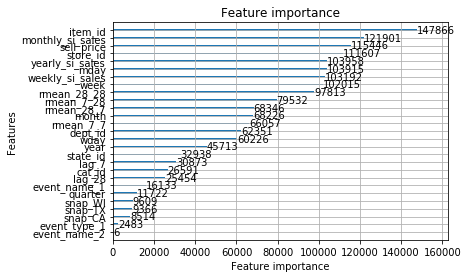

In [78]:
lgb.plot_importance(m_lgb)

## save model

In [79]:
m_lgb.save_model("model_2000_iter2.lgb")



## load model

In [80]:
m_lgb = lgb.Booster(model_file='model_2000_iter2.lgb')
test_size = 50

## feature importance

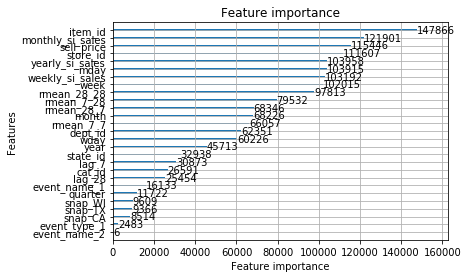

In [81]:
lgb.plot_importance(m_lgb)

## Prediction on unseen data

In [82]:
%%time
# alphas = [1.028, 1.023, 1.018]
alphas = [1.023, 1.018, 1.013] # We decrease alphas a little bit because we thought Trend May < Trend April
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in tqdm(enumerate(zip(alphas, weights))):

    te = create_dt(False)
    print(te.shape)
    te = merging_tables_left(te, df_weekly_season_sales)
    print("Missing count weekly seasonality feature --> ", str(te['weekly_si_sales'].isna().sum()))
    te['weekly_si_sales'] = te.groupby(['id'])['weekly_si_sales'].transform(lambda x: x.fillna(x.median()))
    te = merging_tables_left(te, df_monthly_season_sales)
    print("Missing count monthly seasonality feature --> ", str(te['monthly_si_sales'].isna().sum()))
    te['monthly_si_sales'] = te.groupby(['id'])['monthly_si_sales'].transform(lambda x: x.fillna(x.median()))
    te = merging_tables_left(te, df_yearly_season_sales)
    print("Missing count yearly seasonality feature --> ", str(te['yearly_si_sales'].isna().sum()))
    te['yearly_si_sales'] = te.groupby(['id'])['yearly_si_sales'].transform(lambda x: x.fillna(x.median()))
    print("seasonlaity features merge done")
    print(te.shape)
    print("first processing done!!")
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in tqdm(range(0, 28)):
        day = fday + timedelta(days=tdelta)
        print("############ Processing ---> ", str(day))
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        print(tst.shape)
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        print(tst.shape)
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev
        print("done")


    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_local_{test_size}_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)

print("Done!! Done!!")


# sub2 = sub.copy()
# sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")

# sub2 = pd.read_csv("sales_train_evaluation.csv", usecols = ["id"]+ [f"d_{i}" for i in range(1914, 1914+28)])
# sub2.rename(columns = {f"d_{i}": f'F{i-1913}' for i in range(1914, 1914+28)}, inplace=True)
# sub2["id"] = sub2["id"].str.replace("evaluation", "validation")

# sub = pd.concat([sub, sub2], axis=0, sort=False)
# sub.to_csv("submission.csv",index=False)
# print(sub.shape)


reducing memory
Mem. usage decreased to 147.54 Mb (29.8% reduction)
(2622140, 22)
['id', 'wday']
Missing count weekly seasonality feature -->  86
['id', 'month']
Missing count monthly seasonality feature -->  3050
['id', 'year']
Missing count yearly seasonality feature -->  86
seasonlaity features merge done
(2622140, 25)
first processing done!!


############ Processing --->  2016-05-23 00:00:00
0 2016-05-23 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-24 00:00:00
1 2016-05-24 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-25 00:00:00
2 2016-05-25 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-26 00:00:00
3 2016-05-26 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-27 00:00:00
4 2016-05-27 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-28 00:00:00
5 2016-05-28 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reductio

############ Processing --->  2016-05-23 00:00:00
0 2016-05-23 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-24 00:00:00
1 2016-05-24 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-25 00:00:00
2 2016-05-25 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-26 00:00:00
3 2016-05-26 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-27 00:00:00
4 2016-05-27 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-28 00:00:00
5 2016-05-28 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reductio

############ Processing --->  2016-05-23 00:00:00
0 2016-05-23 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-24 00:00:00
1 2016-05-24 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-25 00:00:00
2 2016-05-25 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-26 00:00:00
3 2016-05-26 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-27 00:00:00
4 2016-05-27 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reduction)
(30490, 28)
done
############ Processing --->  2016-05-28 00:00:00
5 2016-05-28 00:00:00
(1768420, 25)
reducing memory
Mem. usage decreased to 134.92 Mb (5.9% reductio

# Final Submission

In [ ]:
eval_data = pd.read_csv("submission_local_1.csv")
eval_data["id"] = eval_data["id"].str.replace("validation$", "evaluation")


valid_data = pd.read_csv("sales_train_evaluation.csv", usecols = ["id"]+ [f"d_{i}" for i in range(1914, 1914+28)])
valid_data.rename(columns = {f"d_{i}": f'F{i-1913}' for i in range(1914, 1914+28)}, inplace=True)
valid_data["id"] = valid_data["id"].str.replace("evaluation", "validation")

sub = pd.concat([eval_data, valid_data], ignore_index = True, axis=0, sort=False)
# sub.to_csv("submission.csv",index=False)


reducing memory
Mem. usage decreased to 147.54 Mb (29.8% reduction)
do
############ Processing --->  2016-06-01 00:00:00
9 2016-06-01 00:00:00
(1768420, 22)


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
213433,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1894,4.0,2016-04-05,11610,5,4,4,2016,0,0,0,0,1.0,1.0,1.0,8.257812
213434,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1895,2.0,2016-04-06,11610,6,5,4,2016,0,0,0,0,1.0,1.0,1.0,8.257812
213435,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1896,3.0,2016-04-07,11610,4,6,4,2016,0,0,0,0,1.0,1.0,0.0,8.257812
213436,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1897,0.0,2016-04-08,11610,0,7,4,2016,0,0,0,0,1.0,0.0,1.0,8.257812
213440,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_1894,0.0,2016-04-05,11610,5,4,4,2016,0,0,0,0,1.0,1.0,1.0,3.970703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134293,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1947,NaN,2016-05-28,11618,2,1,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000
2134294,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1948,NaN,2016-05-29,11618,3,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000
2134295,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1949,NaN,2016-05-30,11618,1,3,5,2016,15,2,0,0,0.0,0.0,0.0,1.000000
2134296,FOODS_3_827_WI_3_evaluation,3048,6,9,2,2,d_1950,NaN,2016-05-31,11618,5,4,5,2016,0,0,0,0,0.0,0.0,0.0,1.000000


In [2]:
os.listdir()

['submission_2.csv',
 'model_800.lgb',
 'submission_1.csv',
 'submission_darker_magic.csv',
 'submission_0.csv',
 'sales_train_evaluation.csv',
 'model_2000_iter2.lgb',
 'submission_local_2800_2.csv',
 'model_2400.lgb',
 'submission_local_2800_1.csv',
 'submission_local_2800_0.csv',
 'datasets_687702_1205782_m5-forecasting-accuracy-publicleaderboard.csv',
 'submission.csv',
 'best_submission_pre_valid.csv',
 'submission_local_250_2.csv',
 'submission_local_2000_2.csv',
 'submission_local_250_1.csv',
 'submission_local_2000_1.csv',
 'calendar.csv',
 'model_2000.lgb',
 'model_250.lgb',
 'submission_local_2000_0.csv',
 'submission_local_250_0.csv',
 'submission_local_200_1.csv',
 'publicleaderboard_rank.csv',
 'submission_local_200_0.csv',
 'submission_local_200_2.csv',
 'sell_prices.csv',
 'model_2800.lgb',
 'submission_local_1000_1.csv',
 'ads_m5_forecasting_demand.ftr',
 'submission_local_800_1.csv',
 'sales_train_validation.csv',
 'submission_local_800_0.csv',
 'submission_local_1000_

In [8]:
df_50_0_0 = pd.read_csv("submission_local_50_0.csv")
df_50_0_1 = pd.read_csv("submission_local_50_1.csv")
df_50_0_2 = pd.read_csv("submission_local_50_2.csv")
df_50_0_0_tmp = pd.concat([df_50_0_0[['id']],df_50_0_0.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
df_50_0_1_tmp = pd.concat([df_50_0_1[['id']],df_50_0_1.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
df_50_0_2_tmp = pd.concat([df_50_0_2[['id']],df_50_0_2.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
out_df_50_0_tmp = pd.concat([df_50_0_0_tmp, df_50_0_1_tmp, df_50_0_2_tmp], axis=0)
print(out_df_50_0_tmp.shape)
out_df_50_0 = out_df_50_0_tmp.groupby('id').sum().reset_index()
print(out_df_50_0.shape)
out_df_50_0.head()

(91470, 29)
(30490, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.987233,0.911233,0.914800,0.851367,1.110333,1.188333,1.087667,0.950100,0.840100,0.896500,0.817000,1.334333,1.271333,1.193167,0.920467,0.873500,0.876967,0.822233,1.151333,1.215000,1.143000,0.857233,0.828767,0.842700,0.772200,1.107667,1.149333,1.084667
1,FOODS_1_001_CA_2_evaluation,0.779900,0.975233,0.705067,0.981433,0.914667,1.214000,1.071667,0.865667,1.038333,0.789567,1.140667,1.126667,1.387000,1.536000,0.924900,1.258500,0.865200,1.257500,1.151167,1.493667,1.174000,0.837800,1.125333,0.845167,1.051667,1.004833,1.239333,1.071333
2,FOODS_1_001_CA_3_evaluation,0.903333,0.737667,0.604000,0.557700,0.977533,1.103333,1.469667,1.177667,0.862467,0.706200,0.670467,1.032000,1.041000,1.331667,1.011500,0.818233,0.681100,0.640200,1.015833,1.102000,1.256000,0.953000,0.760567,0.635100,0.567400,0.914500,1.008667,1.175000
3,FOODS_1_001_CA_4_evaluation,0.349633,0.226267,0.314567,0.379467,0.301267,0.342767,0.322933,0.370133,0.267600,0.336400,0.368867,0.315067,0.363000,0.339067,0.421700,0.299533,0.358167,0.410467,0.323067,0.391867,0.373367,0.427633,0.276333,0.375800,0.415433,0.301267,0.375633,0.334900
4,FOODS_1_001_TX_1_evaluation,0.632100,1.008333,0.813500,0.784100,0.884800,1.102333,0.967433,0.891533,0.909200,0.759667,0.760867,0.795000,0.870900,0.755567,0.641367,0.765833,0.671467,0.719467,0.705067,0.798467,0.739567,0.684600,0.818400,0.865300,0.775767,0.767433,0.838833,0.765833


In [9]:
df_50_1_0 = pd.read_csv("submission_local_2000_0.csv")
df_50_1_1 = pd.read_csv("submission_local_2000_1.csv")
df_50_1_2 = pd.read_csv("submission_local_2000_2.csv")
df_50_1_0_tmp = pd.concat([df_50_1_0[['id']],df_50_1_0.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
df_50_1_1_tmp = pd.concat([df_50_1_1[['id']],df_50_1_1.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
df_50_1_2_tmp = pd.concat([df_50_1_2[['id']],df_50_1_2.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
out_df_50_1_tmp = pd.concat([df_50_1_0_tmp, df_50_1_1_tmp, df_50_1_2_tmp], axis=0)
print(out_df_50_1_tmp.shape)
out_df_50_1 = out_df_50_1_tmp.groupby('id').sum().reset_index()
print(out_df_50_1.shape)
out_df_50_1.head()

(91470, 29)
(30490, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.965033,0.842233,0.840100,0.790500,1.130333,1.181000,1.080667,0.940300,0.799467,0.897000,0.792000,1.332333,1.293333,1.194000,0.920567,0.892067,0.818300,0.765833,1.090000,1.239000,1.179000,0.855133,0.783767,0.797000,0.717933,1.071333,1.155667,1.033667
1,FOODS_1_001_CA_2_evaluation,0.771500,1.040000,0.682167,0.997433,0.879467,1.229500,1.031000,0.865200,1.040333,0.821167,1.142500,1.115333,1.361167,1.486833,0.914333,1.186333,0.858633,1.264333,1.115667,1.496000,1.201667,0.824900,1.109333,0.817700,1.036333,0.935233,1.276667,1.073333
2,FOODS_1_001_CA_3_evaluation,0.898567,0.710467,0.573800,0.554833,0.996767,1.129000,1.496667,1.139833,0.771000,0.702533,0.687867,1.006000,1.001867,1.289000,0.994900,0.772000,0.641900,0.613233,1.000200,1.090667,1.268000,0.906800,0.695467,0.622867,0.562367,0.939933,1.025167,1.214000
3,FOODS_1_001_CA_4_evaluation,0.381567,0.244000,0.340133,0.440400,0.339833,0.378767,0.325500,0.394767,0.306267,0.374100,0.445067,0.381767,0.426933,0.386467,0.511233,0.348633,0.438067,0.532333,0.389567,0.476867,0.432600,0.509767,0.341467,0.425367,0.503467,0.388167,0.466867,0.416000
4,FOODS_1_001_TX_1_evaluation,0.580567,0.966900,0.777000,0.740967,0.811700,0.879933,0.895500,0.822633,0.901467,0.742567,0.731967,0.726067,0.831700,0.741967,0.628600,0.751200,0.601000,0.659800,0.657900,0.717433,0.707167,0.669467,0.783667,0.788600,0.713467,0.743433,0.784767,0.730800


In [10]:
df_70_0_0 = pd.read_csv("submission_local_2800_0.csv")
df_70_0_1 = pd.read_csv("submission_local_2800_1.csv")
df_70_0_2 = pd.read_csv("submission_local_2800_2.csv")
df_70_0_0_tmp = pd.concat([df_70_0_0[['id']],df_70_0_0.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
df_70_0_1_tmp = pd.concat([df_70_0_1[['id']],df_70_0_1.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)
df_70_0_2_tmp = pd.concat([df_70_0_2[['id']],df_70_0_2.select_dtypes(exclude=['object', 'datetime']) * 1/3],axis=1)

out_df_70_0_tmp = pd.concat([df_70_0_0_tmp, df_70_0_1_tmp, df_70_0_2_tmp], axis=0)
print(out_df_70_0_tmp.shape)
out_df_70_0 = out_df_70_0_tmp.groupby('id').sum().reset_index()
print(out_df_70_0.shape)
out_df_70_0.head()

(91470, 29)
(30490, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.888200,0.820900,0.797400,0.750200,1.074333,1.142,1.060333,0.921467,0.7809,0.879600,0.798300,1.331667,1.257667,1.171000,0.887200,0.844333,0.810867,0.753767,1.126333,1.207000,1.193167,0.819000,0.767833,0.809600,0.726700,1.109500,1.118667,1.031000
1,FOODS_1_001_CA_2_evaluation,0.676100,0.937800,0.640767,1.026000,0.894500,1.105,0.981000,0.747700,1.0010,0.799233,1.113333,1.134667,1.388833,1.438000,0.883000,1.184667,0.832300,1.305667,1.096667,1.490000,1.234667,0.759033,1.136333,0.781767,1.079333,0.906567,1.260667,1.079333
2,FOODS_1_001_CA_3_evaluation,0.880100,0.680500,0.500967,0.474200,1.009000,1.047,1.413333,1.106000,0.7477,0.676333,0.640400,1.039333,0.962167,1.230333,0.992767,0.764733,0.597867,0.545167,0.975700,1.007667,1.234000,0.887667,0.681200,0.590000,0.505467,0.959633,0.974000,1.146000
3,FOODS_1_001_CA_4_evaluation,0.395767,0.239767,0.346933,0.459400,0.316467,0.365,0.323133,0.380967,0.2797,0.380367,0.435800,0.373433,0.413133,0.372700,0.488033,0.326367,0.429367,0.511867,0.389133,0.468267,0.438833,0.544300,0.346933,0.460933,0.516433,0.392133,0.464600,0.417300
4,FOODS_1_001_TX_1_evaluation,0.583000,0.955667,0.766233,0.760967,0.838233,1.026,0.965667,0.957200,0.9802,0.818400,0.838400,0.825300,0.884700,0.810000,0.684867,0.826833,0.680800,0.750000,0.730367,0.811133,0.792000,0.709967,0.871967,0.828600,0.781533,0.832133,0.868833,0.780900


In [11]:
out_1_tmp = pd.concat([out_df_50_0[['id']],out_df_50_0.select_dtypes(exclude=['object', 'datetime']) * 0.6],axis=1)
out_2_tmp = pd.concat([out_df_50_1[['id']],out_df_50_1.select_dtypes(exclude=['object', 'datetime']) * 0.4],axis=1)
out_3_tmp = pd.concat([out_df_70_0[['id']],out_df_70_0.select_dtypes(exclude=['object', 'datetime']) * 0.0],axis=1)


In [12]:
final_out_tmp = pd.concat([out_1_tmp, out_2_tmp, out_3_tmp], axis=0)
print(final_out_tmp.shape)
final_out = final_out_tmp.groupby('id').sum().reset_index()
print(final_out.shape)
final_out.head()

(91470, 29)
(30490, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.978353,0.883633,0.884920,0.827020,1.118333,1.185400,1.084867,0.946180,0.823847,0.896700,0.807000,1.333533,1.280133,1.193500,0.920507,0.880927,0.853500,0.799673,1.126800,1.224600,1.157400,0.856393,0.810767,0.824420,0.750493,1.093133,1.151867,1.064267
1,FOODS_1_001_CA_2_evaluation,0.776540,1.001140,0.695907,0.987833,0.900587,1.220200,1.055400,0.865480,1.039133,0.802207,1.141400,1.122133,1.376667,1.516333,0.920673,1.229633,0.862573,1.260233,1.136967,1.494600,1.185067,0.832640,1.118933,0.834180,1.045533,0.976993,1.254267,1.072133
2,FOODS_1_001_CA_3_evaluation,0.901427,0.726787,0.591920,0.556553,0.985227,1.113600,1.480467,1.162533,0.825880,0.704733,0.677427,1.021600,1.025347,1.314600,1.004860,0.799740,0.665420,0.629413,1.009580,1.097467,1.260800,0.934520,0.734527,0.630207,0.565387,0.924673,1.015267,1.190600
3,FOODS_1_001_CA_4_evaluation,0.362407,0.233360,0.324793,0.403840,0.316693,0.357167,0.323960,0.379987,0.283067,0.351480,0.399347,0.341747,0.388573,0.358027,0.457513,0.319173,0.390127,0.459213,0.349667,0.425867,0.397060,0.460487,0.302387,0.395627,0.450647,0.336027,0.412127,0.367340
4,FOODS_1_001_TX_1_evaluation,0.611487,0.991760,0.798900,0.766847,0.855560,1.013373,0.938660,0.863973,0.906107,0.752827,0.749307,0.767427,0.855220,0.750127,0.636260,0.759980,0.643280,0.695600,0.686200,0.766053,0.726607,0.678547,0.804507,0.834620,0.750847,0.757833,0.817207,0.751820


In [13]:
sub2 = pd.read_csv("sales_train_evaluation.csv", usecols = ["id"]+ [f"d_{i}" for i in range(1914, 1914+28)])
sub2.rename(columns = {f"d_{i}": f'F{i-1913}' for i in range(1914, 1914+28)}, inplace=True)
sub2["id"] = sub2["id"].str.replace("evaluation", "validation")

out = pd.concat([sub2, final_out], axis=0, sort=False)
out.to_csv("/Users/Paritosh_Gupta/Desktop/submission1.csv",index=False)


In [14]:
out.shape

(60980, 29)

In [15]:
df_70_0_0 = pd.read_csv("submission_local_2800_0.csv")
